In [1]:
# ===== Load Cleaned Data =====
import os, sys

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

import pickle

In [2]:
# Get the absolute path to the project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add to sys.path if not already there
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.config import DATA_PROCESSED, MODELS_DIR

In [3]:
# Load train and test
train_df = pd.read_csv(os.path.join(DATA_PROCESSED, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_PROCESSED, "test.csv"))

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5090096 entries, 0 to 5090095
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   step                   int64  
 1   type                   object 
 2   amount                 float64
 3   oldbalanceOrg          float64
 4   newbalanceOrig         float64
 5   oldbalanceDest         float64
 6   isFraud                int64  
 7   flag_dest_new_account  int64  
 8   transaction_hour       int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 349.5+ MB


In [5]:
features_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'transaction_hour', 'step']

In [6]:
# Initialize scaler
scaler = StandardScaler()

In [7]:
from imblearn.over_sampling import ADASYN

In [8]:
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

In [9]:
# Fit on train, transform both
train_df_scaled[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
test_df_scaled[features_to_scale] = scaler.transform(test_df[features_to_scale])

In [10]:
X_train = train_df_scaled[features_to_scale]
y_train = train_df['isFraud']
X_test = test_df_scaled[features_to_scale]
y_test = test_df['isFraud']

In [11]:
# # Apply ADASYN oversampling
# adasyn = ADASYN(sampling_strategy=0.2,  # fraud = 20% of non-fraud
#                 n_neighbors=5,
#                 random_state=42)

# X_train, y_train = adasyn.fit_resample(X_train, y_train)

In [12]:
print("Train and test data prepared and scaled.")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Train and test data prepared and scaled.
(5090096, 6) (5090096,)
(1272524, 6) (1272524,)


In [13]:
print(y_train.value_counts())
print(y_test.value_counts())

isFraud
0    5083526
1       6570
Name: count, dtype: int64
isFraud
0    1270881
1       1643
Name: count, dtype: int64


In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5090096 entries, 0 to 5090095
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   amount            float64
 1   oldbalanceOrg     float64
 2   newbalanceOrig    float64
 3   oldbalanceDest    float64
 4   transaction_hour  float64
 5   step              float64
dtypes: float64(6)
memory usage: 233.0 MB


In [15]:
# Save scaler to models folder
scaler_path = os.path.join(MODELS_DIR, "scaler.pkl")
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)

In [16]:
import optuna
import pickle
import os
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, recall_score, classification_report


c:\Users\DELL\Documents\PRAXIS\Projects\onlinefraud_Bank_project\bankEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# List of models to try
models = {
    "LogisticRegression": LogisticRegression(class_weight="balanced", random_state=42, max_iter=300),
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss", n_jobs=-1, scale_pos_weight=sum(y_train==0)/sum(y_train==1))
}

results = []

for name, model in models.items():
    print(f"Training {name}...")
    pipe = Pipeline([
        ("scaler", scaler),  # Optional for tree models, harmless
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    cm = confusion_matrix(y_test, preds)
    recall = recall_score(y_test, preds, pos_label=1)
    
    results.append({
        "model": name,
        "confusion_matrix": cm,
        "recall": recall,
        "classification_report": classification_report(y_test, preds, digits=4)
    })

# Display results
for res in results:
    print(f"\nModel: {res['model']}")
    print("Confusion Matrix:\n", res["confusion_matrix"])
    print("Recall:", res["recall"])
    print("Classification Report:\n", res["classification_report"])

Training LogisticRegression...
Training RandomForest...
Training XGBoost...

Model: LogisticRegression
Confusion Matrix:
 [[1213456   57425]
 [    226    1417]]
Recall: 0.8624467437614121
Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9548    0.9768   1270881
           1     0.0241    0.8624    0.0469      1643

    accuracy                         0.9547   1272524
   macro avg     0.5119    0.9086    0.5118   1272524
weighted avg     0.9986    0.9547    0.9756   1272524


Model: RandomForest
Confusion Matrix:
 [[1270843      38]
 [    413    1230]]
Recall: 0.7486305538648813
Classification Report:
               precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998   1270881
           1     0.9700    0.7486    0.8451      1643

    accuracy                         0.9996   1272524
   macro avg     0.9849    0.8743    0.9224   1272524
weighted avg     0.9996    0.9996    0.9996   1272524


Mod

In [18]:
def objective(trial):
    # Suggest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "scale_pos_weight": sum(y_train == 0) / sum(y_train == 1),  # handle class imbalance
        "random_state": 42,
        "eval_metric": "logloss",
        "n_jobs": -1
    }
    
    # Build pipeline
    pipe = Pipeline([
        ("scaler", StandardScaler()),  # optional for tree models
        ("xgb", XGBClassifier(**params))
    ])
    
    # Fit on train
    pipe.fit(X_train, y_train)
    
    # Predict on validation/test
    preds = pipe.predict(X_test)
    
    # Return recall for fraud class (1)
    return recall_score(y_test, preds, pos_label=1)

In [19]:
study = optuna.create_study(direction="maximize", study_name="xgboost_fraud_recall")
study.optimize(objective, n_trials=30)  # you can increase n_trials for better tuning

[I 2025-08-15 23:41:50,414] A new study created in memory with name: xgboost_fraud_recall
[I 2025-08-15 23:44:50,739] Trial 0 finished with value: 0.995739500912964 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.019141507690977756, 'subsample': 0.9066563090708416, 'colsample_bytree': 0.8651569037110571}. Best is trial 0 with value: 0.995739500912964.
[I 2025-08-15 23:46:06,413] Trial 1 finished with value: 0.9933049300060864 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.2195399277764417, 'subsample': 0.849360519648745, 'colsample_bytree': 0.9190880124630323}. Best is trial 0 with value: 0.995739500912964.
[I 2025-08-15 23:51:43,369] Trial 2 finished with value: 0.960438222763238 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1199531653472307, 'subsample': 0.706992457857579, 'colsample_bytree': 0.6750418886416305}. Best is trial 0 with value: 0.995739500912964.
[I 2025-08-15 23:53:02,291] Trial 3 finished wi

In [20]:
# Best Hyperparameters
print("Best Recall:", study.best_value)
print("Best Parameters:", study.best_params)

Best Recall: 0.996956786366403
Best Parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.15388808132322063, 'subsample': 0.8142560905856004, 'colsample_bytree': 0.99117560762299}


In [21]:
# Best Recall: 0.9963481436396835
# Best Parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.09063874396765441, 'subsample': 0.9584461997882531, 'colsample_bytree': 0.8675132864407697}

In [ ]:
# Fit final model with best params
# best_params = study.best_params     #uncomment this line when using Optuna

#as optuna is already executed we can use the best_params directly
Best_Parameters= {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.15388808132322063, 'subsample': 0.8142560905856004, 'colsample_bytree': 0.99117560762299}
best_params = Best_Parameters
best_params["scale_pos_weight"] = sum(y_train == 0) / sum(y_train == 1)
best_params["random_state"] = 42
best_params["eval_metric"] = "logloss"
best_params["n_jobs"] = -1

final_pipe = Pipeline([
    ("scaler", scaler),
    ("xgb", XGBClassifier(**best_params))
])

In [23]:
# Fit final model
final_pipe.fit(X_train, y_train)

# Predictions
preds_train = final_pipe.predict(X_train)
preds_test = final_pipe.predict(X_test)

# Probabilities for ROC-AUC
proba_train = final_pipe.predict_proba(X_train)[:,1]
proba_test = final_pipe.predict_proba(X_test)[:,1]

In [24]:
# Evaluate final model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# =============================
# Evaluate Train Metrics
# =============================
print("====== TRAIN METRICS ======")
print("Confusion Matrix:\n", confusion_matrix(y_train, preds_train))
print("\nClassification Report:\n", classification_report(y_train, preds_train, digits=4))
print("ROC-AUC Score:", roc_auc_score(y_train, proba_train))

# =============================
# Evaluate Test Metrics
# =============================
print("\n====== TEST METRICS ======")
print("Confusion Matrix:\n", confusion_matrix(y_test, preds_test))
print("\nClassification Report:\n", classification_report(y_test, preds_test, digits=4))
print("ROC-AUC Score:", roc_auc_score(y_test, proba_test))

====== TRAIN METRICS ======
Confusion Matrix:
 [[5036570   46956]
 [      5    6565]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9908    0.9954   5083526
           1     0.1227    0.9992    0.2185      6570

    accuracy                         0.9908   5090096
   macro avg     0.5613    0.9950    0.6069   5090096
weighted avg     0.9989    0.9908    0.9944   5090096

ROC-AUC Score: 0.9997832726652531

====== TEST METRICS ======
Confusion Matrix:
 [[1259202   11679]
 [      5    1638]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9908    0.9954   1270881
           1     0.1230    0.9970    0.2190      1643

    accuracy                         0.9908   1272524
   macro avg     0.5615    0.9939    0.6072   1272524
weighted avg     0.9989    0.9908    0.9944   1272524

ROC-AUC Score: 0.9994453232205389


In [25]:
# Save final pipeline
pipeline_path = os.path.join(MODELS_DIR, "fraud_detection_pipeline.pkl")
with open(pipeline_path, "wb") as f:
    pickle.dump(final_pipe, f)

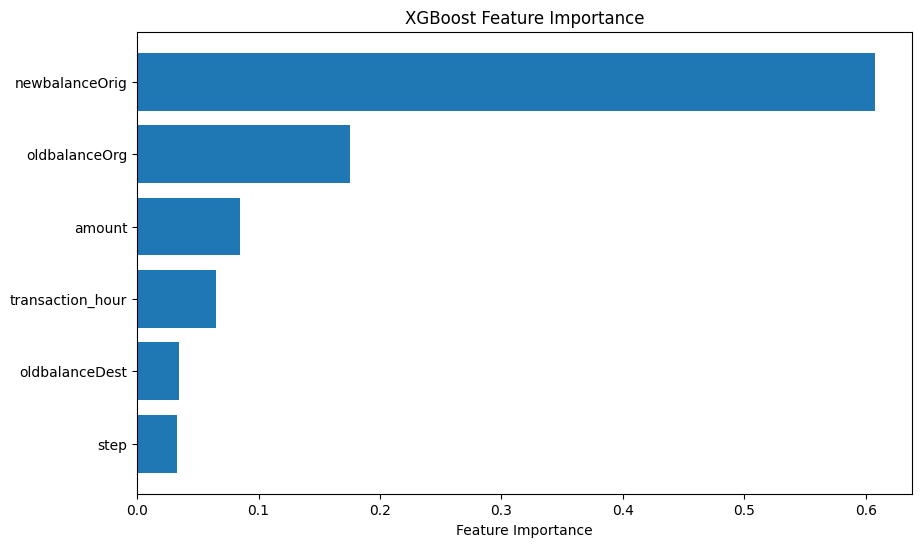

In [26]:
# #XGB model feature importance
import matplotlib.pyplot as plt

# Get feature importance from the model, sorted
importance = final_pipe.named_steps['xgb'].feature_importances_

sorted_idx = np.argsort(importance) 

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance)), importance[sorted_idx], align='center')
plt.yticks(range(len(importance)), X_train.columns[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()

In [27]:
import shap

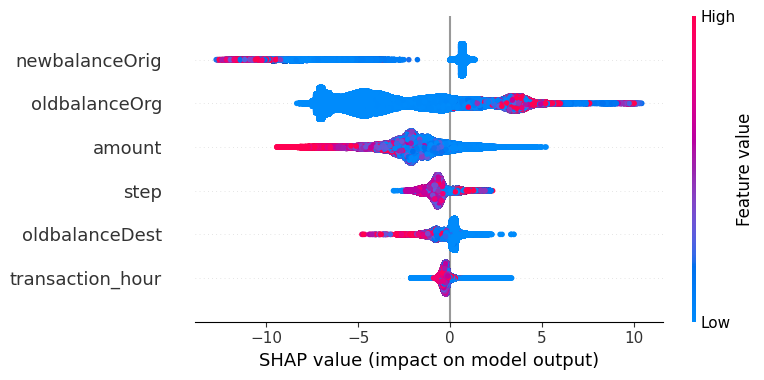

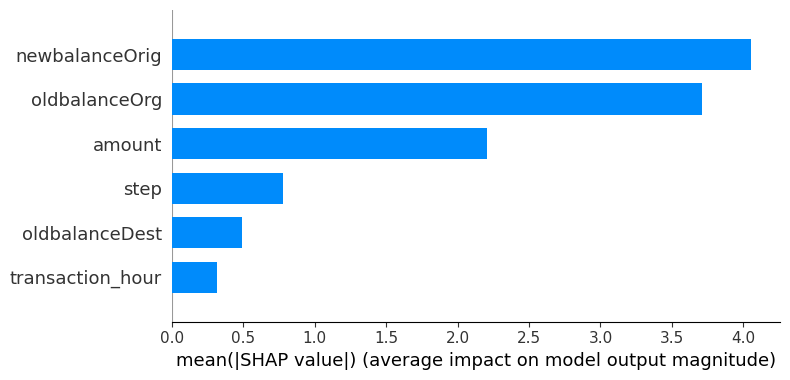

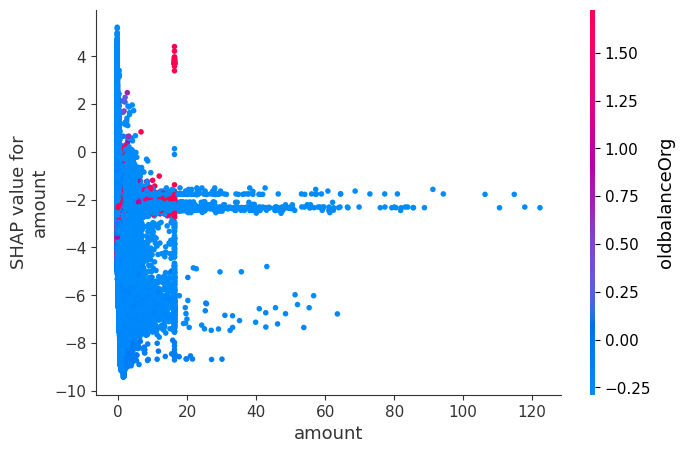

newbalanceOrig      4.054286
oldbalanceOrg       3.711240
amount              2.207393
step                0.775931
oldbalanceDest      0.493280
transaction_hour    0.314746
dtype: float32


In [28]:
# Optional: sample X_test for large datasets
# sample_size = 10000
# X_sample = X_test.sample(sample_size, random_state=42) if len(X_test) > sample_size else X_test
X_sample = X_test  # Use the entire test set for SHAP analysis

# Initialize TreeExplainer using the pipeline's best model
explainer = shap.TreeExplainer(final_pipe.named_steps['xgb'])

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# 2a. Summary plot (dot style)
shap.summary_plot(shap_values, X_sample, plot_type="dot")

# 2b. Summary plot (bar style)
shap.summary_plot(shap_values, X_sample, plot_type="bar")

# 2c. Dependence plot for one feature
feature_name = X_sample.columns[0]  # replace with any feature name
shap.dependence_plot(feature_name, shap_values, X_sample)

# 2d. Optional: mean absolute SHAP values as DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_sample.columns)
mean_shap = shap_df.abs().mean().sort_values(ascending=False)
print(mean_shap)

In [29]:
train_df[train_df['isFraud'] == 1]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,isFraud,flag_dest_new_account,transaction_hour
679,106,CASH_OUT,2231.46,2231.46,0.0,0.0,1,1,10
1271,253,TRANSFER,168622.30,168622.30,0.0,0.0,1,1,13
1762,507,TRANSFER,2291498.65,2291498.65,0.0,0.0,1,1,3
2997,81,TRANSFER,1980800.05,1980800.05,0.0,0.0,1,1,9
5067,274,CASH_OUT,49210.21,49210.21,0.0,0.0,1,1,10
...,...,...,...,...,...,...,...,...,...
5086989,531,TRANSFER,834203.65,834203.65,0.0,0.0,1,1,3
5087904,520,TRANSFER,1459180.14,1459180.14,0.0,0.0,1,1,16
5088036,631,CASH_OUT,3120690.98,3120690.98,0.0,3881444.6,1,0,7
5089679,675,TRANSFER,1091589.88,1091589.88,0.0,0.0,1,1,3
